## Load data yang dibutuhkan

Untuk data gizi pakai data konsumsi di tahun 2012 dulu

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data susenas 2012 modul konsumsi
sus12_kons_amt = pd.read_csv('./susenas12/sn12_m41p1.csv')
sus12_kons_gizi = pd.read_csv('./susenas12/sn12_m41p2.csv')
sus12_kons_gabungan = pd.read_csv('./susenas12/sn12_m43.csv')

# load data susenas 2013 modul konsumsi
sus13_con = pd.read_csv('./susenas13/sn13_m41.csv')

In [3]:
# load data susenas modul individu dan rumah tangga jika diperlukan
sus12_indv = pd.read_csv('./susenas12/sn12_ki.csv')
sus12_rt = pd.read_csv('./susenas12/sn12_krt.csv')

In [4]:
sus12_kons_gizi.head()

,URUT,B1R1,B1R2,B1R5,B1R8,B2R1,KODE,KLP,KALORI,PROTEIN,LEMAK,KARBO,WERT,WEIND
0,110112500101601,11,1,1,1,4,1,0,21732.0,508.5,87.00,4653.0,45.876255,183.50502
1,110112500101601,11,1,1,1,4,2,1,21732.0,508.5,87.00,4653.0,45.876255,183.50502
2,110112500101601,11,1,1,1,4,20,0,2269.0,369.3,77.04,0.9,45.876255,183.50502
3,110112500101601,11,1,1,1,4,22,20,904.0,136.0,36.00,0.0,45.876255,183.50502
4,110112500101601,11,1,1,1,4,34,20,904.0,136.0,36.00,0.0,45.876255,183.50502


In [5]:
sus12_kons_gabungan.head()

,URUT,B1R1,B1R2,B1R5,B1R8,B2R1,FOOD,NFOOD,EXPEND,KAPITA,KALORI,WERT,WEIND,EXP_CAP,KABU
0,110112500101601,11,1,1,1,4,8.168571e+05,5.570000e+05,1.373857e+06,3.434643e+05,1277.633929,45.876255,183.505020,3.434643e+05,1101
1,110112500101602,11,1,1,2,4,1.334571e+06,9.466667e+05,2.281238e+06,5.703095e+05,1793.693929,55.252186,221.008743,5.703095e+05,1101
2,110112500101603,11,1,1,3,4,2.901429e+06,2.321667e+06,5.223095e+06,1.305774e+06,2593.590357,20.006414,80.025658,1.305774e+06,1101
3,110112500101604,11,1,1,4,6,1.394571e+06,1.016000e+06,2.410571e+06,4.017619e+05,1430.819048,42.398369,254.390213,4.017619e+05,1101
4,110112500101605,11,1,1,5,4,1.588286e+06,1.212000e+06,2.800286e+06,7.000714e+05,1482.632143,43.420265,173.681061,7.000714e+05,1101


### Perbaikan untuk kolom WERT dan WEIND 

Data weind dan wert adalah weighting individu dan weighting rumah tangga, dimana wert adalah weind * jumlah anggota rumah tangga di dalam rumah tangga tersebut. Sekilas melihat data susenas 2012 dan 2013 justru terjadi kebalikannya yaitu weind = wert * jumlah Anggota rumah tangga. Agar konsisten, maka kita tukar saja nama

In [6]:
tukar = {"WERT":"WEIND","WEIND":"WERT"}
sus12_kons_amt = sus12_kons_amt.rename(columns=tukar)
sus12_kons_gabungan = sus12_kons_gabungan.rename(columns=tukar)
sus12_kons_gizi = sus12_kons_gizi.rename(columns=tukar)

### Validasi metode perhitungan angka indikator gizi

Data konsumsi kalori per kapita untuk tiap rumah tangga telah tersedia di bagian susenas konsumsi blok 43, namun data untuk konsumsi protein,lemak, dll. tidak tersedia di dataset tersebut. Maka dapat menggunakan data konsumsi blok 41 dengan cara aggregasi tiap rumah tangga. Untuk memastikan bahwa metode aggregasi dan perhitungan konsumsi indikator gizi telah sesuai, di bawah ini dilakukan perbandingan antara perhitungan kalori per hari/kapita untuk 1 rumah tangga dari modul konsumsi blok 41 dengan data dari blok 43

In [7]:
# Kode dari group makanan yang akan dimasukkan ke dalam perhitungan
# untuk mencegah adanya duplikasi perhitungan antara grup dan tiap item individual ,
# misal kode 1 = total untuk padi-padian, kode 2 = beras tidak dimasukkan karena merupakan bagian dari kelompok 1
food_code = [1, 10, 20, 53, 71, 85, 115, 127, 151, 158, 167, 181, 191]

# cek data kalori di modul konsumsi 
# ambil sampel satu rumah tangga untuk dihitung kalorinya
sample_rt = sus12_kons_gizi.iloc[1,0]
data_sample = sus12_kons_gizi.loc[(sus12_kons_gizi['KODE'].isin(food_code)) & (sus12_kons_gizi['URUT'] == sample_rt)]

data_sample_grouped = data_sample.groupby('URUT').agg(kalori = ("KALORI", 'sum')) # jumlah kalori per minggu untuk 1 rt
print(data_sample_grouped/7/4) # jumlah kalori per hari/kapita , dibagi 4 karena anggota keluarganya ada 4

# bandingkan dengan data di konsumsi gabungan
comparison = sus12_kons_gabungan.loc[sus12_kons_gabungan['URUT'] == sample_rt, 'KALORI']
comparison

                      kalori
URUT                        
110112500101601  1277.633929


0    1277.633929
Name: KALORI, dtype: float64

Angkanya sama, maka metode ini bisa digunakan

In [8]:
data_sample

,URUT,B1R1,B1R2,B1R5,B1R8,B2R1,KODE,KLP,KALORI,PROTEIN,LEMAK,KARBO,WEIND,WERT
0,110112500101601,11,1,1,1,4,1,0,21732.00,508.500,87.000,4653.000,45.876255,183.50502
2,110112500101601,11,1,1,1,4,20,0,2269.00,369.300,77.040,0.900,45.876255,183.50502
6,110112500101601,11,1,1,1,4,71,0,685.30,55.180,48.060,3.115,45.876255,183.50502
8,110112500101601,11,1,1,1,4,85,0,253.80,14.520,3.030,37.935,45.876255,183.50502
13,110112500101601,11,1,1,1,4,115,0,904.00,50.600,85.600,42.200,45.876255,183.50502
15,110112500101601,11,1,1,1,4,127,0,928.80,11.180,2.580,242.520,45.876255,183.50502
17,110112500101601,11,1,1,1,4,151,0,4943.50,12.650,316.120,52.100,45.876255,183.50502
20,110112500101601,11,1,1,1,4,158,0,3992.00,17.400,1.300,1009.000,45.876255,183.50502
23,110112500101601,11,1,1,1,4,167,0,65.35,3.352,1.003,14.442,45.876255,183.50502
27,110112500101601,11,1,1,1,4,191,0,0.00,0.000,0.000,0.000,45.876255,183.50502


# 1. Perhitungan AKG per kapita/hari (kalori,lemak,protein,karbohidrat)

Pertama buat aggregasi untuk tiap rumah tangga dengan groupby nomor urut rumah tangga

In [9]:
# filter berdasarkan group / kelompok makanan
gizi_weekly= sus12_kons_gizi.loc[(sus12_kons_gizi['KODE'].isin(food_code))]

# grouping per rumah tangga
# WEIND, WERT , dan B2R1 aggregasi mean karena nilainya untuk tiap rumah tangga sama
gizi_grouped_weekly = gizi_weekly.groupby('URUT').agg(kalori = ('KALORI', 'sum'),
                                                     protein = ('PROTEIN', 'sum'),
                                                     lemak = ('LEMAK', 'sum'),
                                                     karbohidrat = ('KARBO', 'sum'),
                                                     WERT = ('WERT', 'mean'),
                                                     WEIND = ('WEIND', 'mean'),
                                                     jumlah_art = ('B2R1', 'mean')). reset_index()
gizi_grouped_weekly


,URUT,kalori,protein,lemak,karbohidrat,WERT,WEIND,jumlah_art
0,110112500101601,35773.75,1042.682,621.733,6055.212,183.505020,45.876255,4
1,110112500101602,50223.43,1378.968,1060.152,7904.175,221.008743,55.252186,4
2,110112500101603,72620.53,2102.589,1941.695,10785.024,80.025658,20.006414,4
3,110112500101604,60094.40,1664.150,1014.770,10617.510,254.390213,42.398369,6
4,110112500101605,41513.70,1270.500,921.645,6406.505,173.681061,43.420265,4
...,...,...,...,...,...,...,...,...
286108,947122001103806,48365.80,2037.228,1805.240,6255.670,2190.646820,438.129364,5
286109,947122001103807,68975.98,3158.530,2566.832,7207.554,1605.079956,321.015991,5
286110,947122001103808,30318.58,1376.580,998.652,3922.144,649.540222,324.770111,2
286111,947122001103809,86519.80,2589.050,2170.900,13619.380,98.785879,14.112268,7


### AKG per hari per kapita untuk tiap rumah tangga

In [10]:
# list indikator
indikator = ['kalori', 'protein', 'lemak', 'karbohidrat']

# indikator kecukupan gizi per kapita per hari
gizi_grouped_daily = gizi_grouped_weekly.apply(lambda x: x/7/gizi_grouped_weekly['jumlah_art'] 
                                               if x.name in indikator else x, axis=0)
gizi_grouped_daily

,URUT,kalori,protein,lemak,karbohidrat,WERT,WEIND,jumlah_art
0,110112500101601,1277.633929,37.238643,22.204750,216.257571,183.505020,45.876255,4
1,110112500101602,1793.693929,49.248857,37.862571,282.291964,221.008743,55.252186,4
2,110112500101603,2593.590357,75.092464,69.346250,385.179429,80.025658,20.006414,4
3,110112500101604,1430.819048,39.622619,24.161190,252.797857,254.390213,42.398369,6
4,110112500101605,1482.632143,45.375000,32.915893,228.803750,173.681061,43.420265,4
...,...,...,...,...,...,...,...,...
286108,947122001103806,1381.880000,58.206514,51.578286,178.733429,2190.646820,438.129364,5
286109,947122001103807,1970.742286,90.243714,73.338057,205.930114,1605.079956,321.015991,5
286110,947122001103808,2165.612857,98.327143,71.332286,280.153143,649.540222,324.770111,2
286111,947122001103809,1765.710204,52.837755,44.304082,277.946531,98.785879,14.112268,7


###  Simple visualisation dari data AKG per kapita harian

Kita coba visualisasikan bagaimana distribusi dari tiap komponen akg sepanjang seluruh rumah tangga, apakah ada nilai outlier atau yang na

In [11]:
cek_gizi = gizi_grouped_daily.drop(['URUT','WERT','WEIND','jumlah_art'], axis = 1)
cek_gizi.isna().sum()

kalori         0
protein        0
lemak          0
karbohidrat    0
dtype: int64

Tidak ada missing value untuk masing2 variabel. Sekarang kita coba buat simple visualisation

In [12]:
# but first simple describe() function won't hurt
cek_gizi.describe()

,kalori,protein,lemak,karbohidrat
count,286113.000000,286113.000000,286113.000000,286113.000000
mean,1981.511723,56.955433,45.582531,308.806994
std,616.318013,21.970385,23.595291,100.003969
min,1000.007381,5.070500,1.807619,13.805714
25%,1538.297714,42.205807,29.997557,238.396173
50%,1874.465429,52.788452,40.974714,292.226696
75%,2299.125429,66.740736,55.632857,360.092041
max,4499.710714,402.423123,344.091968,1012.205000


Median: 1874.4654285714287
Mean: 1981.5117227645228
Std Dev: 616.3169355667993


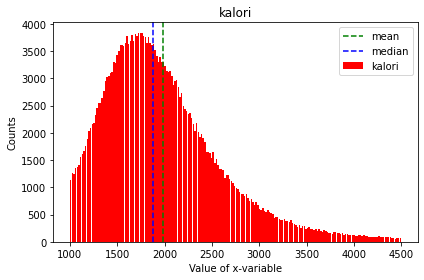

Median: 52.78845238095238
Mean: 56.95543280485254
Std Dev: 21.97034615328678


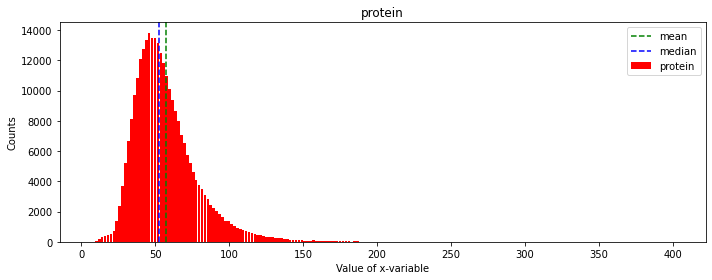

Median: 40.97471428571429
Mean: 45.58253111061863
Std Dev: 23.59525020867958


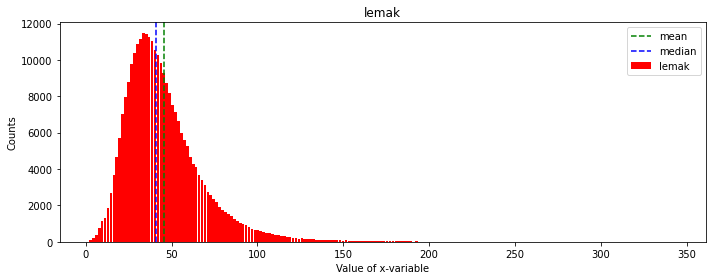

Median: 292.2266964285715
Mean: 308.80699377141013
Std Dev: 100.00379398914502


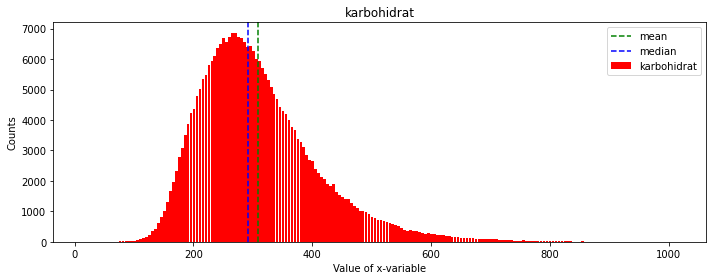

In [13]:
# cek distribusi dengan histogram untuk tiap variabel

for i in cek_gizi.columns:
    cek_gizi[i].plot.hist(grid=False, bins=200, rwidth=0.9,color='red',label=i)
    line1 = plt.axvline(cek_gizi[i].mean(), color="g", linestyle="--", label = "mean")
    line2 = plt.axvline(np.median(cek_gizi[i]), color="b", linestyle="--", label = "median")
    plt.title(i)
    plt.xlabel('Value of x-variable')
    plt.ylabel('Counts')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [10, 4]
    print("Median:", np.median(cek_gizi[i]))
    print("Mean:", cek_gizi[i].mean())
    print("Std Dev:", np.std(cek_gizi[i]))
#     plt.xlim([0,np.quantile(cek_gizi[i],0.95)])
    plt.show()

Secara umum terlihat mengikuti pola distribusi normal, namun tampak masih ada beberapa outliers untuk setiap variabel. Kita coba cek juga dengan menggunakan boxplot

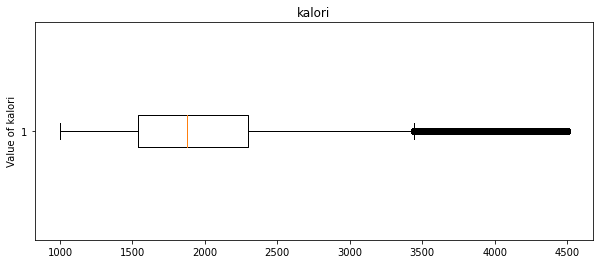

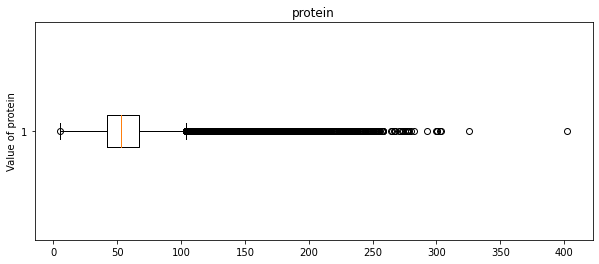

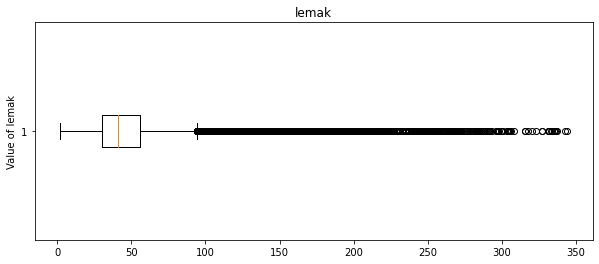

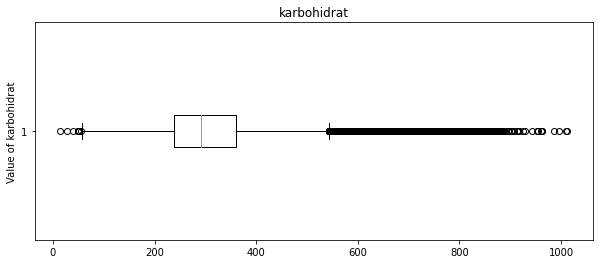

In [22]:
# buat boxplot untuk tiap variable
for i in cek_gizi.columns:
    plt.boxplot(cek_gizi[i], vert=False)
    plt.title(i)
    plt.ylabel('Value of {0}'.format(i))
    plt.show()

Dapat terlihat bahwa untuk setiap variabel masih terdapat beberapa outliers
<ul>
    <li>Pertama karena data berada dalam level rumah tangga, bisa saja ada rumah tangga dengan jumlah ART (anggota rumah tangga) yang cukup banyak dan tiap ART mengkonsumsi dalam jumlah yang banyak pula mengakibatkan angka outliers yang tinggi</li>
    <li>Kedua, karena variabel gizi ini tersusun atas beberapa kelompok makanan, seperti padi-padian, umbi-umbian, dst. , maka ada kemungkinan beberapa kelompok makanan memberikan kontribusi yang jauh lebih besar dibandingkan kelompok makanan lainnya untuk tiap variabel gizi</li>
    <li>Ketiga ada kemungkinan adanya rumah tangga di daerah tertentu yang konsumsinya melebihi daerah lain, dan</li>
    <li>Keempat, rumah tangga yang cenderung lebih kaya mengkonsumsi makanan dalam jumlah lebih banyak ataupun makanan-makanan yang cenderung lebih berkualitas (kontribusi gizinya lebih tinggi) dibandingkan rumah tanggal lain sehingga menjadi outliers. Hipotesa ini akan diuji lebih jauh di bagian selanjutnya (korelasi konsumsi dan tingkat pengeluaran per rumah tangga)</li>
</ul>
    

In [23]:
# kita buat fungsi untuk mengecek berapa banyak outliers untuk tiap kolom di data gizi weekly sebelum
# kita hitung akg per kapita per hari

# cek persentase outlier per kolom, dan impute jika diinginkan
def get_outliers(data_init,list_of_cols,impute = False, method='median'):
    data = data_init.copy()
    jumlah_outliers={}
    for col in list_of_cols:
        out = np.quantile(data[col],0.75) + 1.5 * (np.quantile(data[col],0.75)-
                                                              np.quantile(data[col],0.25))
        nums = len(data.loc[data[col] > out ,col])/data_init.shape[0] * 100
        jumlah_outliers[col] = nums
        if impute and method == 'median':
            data.loc[data[col] > out ,col] = data_init[col].median()
    return data, jumlah_outliers
gizi_grouped_daily_norms, outliers = get_outliers(gizi_grouped_daily,list(cek_gizi.columns),impute = True)

In [24]:
outliers

{'kalori': 3.064872969770685,
 'protein': 3.725101620688329,
 'lemak': 3.790809924750011,
 'karbohidrat': 2.8768353762324677}

Dapat terlihat bahwa persentase data yang termasuk outliers cukup kecil dibandingkan data aslinya, sehingga dapat dilakukan imputasi atau bahkan dapat dikeluarkan. Namun concern penulis untuk imputasi data adalah bahwa dengan memodifikasi nilai ataupun menghapus data akan memerlukan penyesuaian di weighting, yang nantinya akan berdampak pada analisa ke depannya. Untuk itu penulis memutuskan untuk membiarkan nilai outlier untuk analisis saat ini

### Cek outlier per kelompok quantile pengeluaran sebagai proxy dari pendapatan

Ada baiknya kita cek juga outlier setelah kita kelompokkan rumah tangga dalam quantile pengeluaran. Notes bahwa exercise ini dilakukan dalam level *rumah tangga* dan dengan mengesampingkan fakta bahwa :
Data pengeluaran susenas 2012 bukanlah data pengeluaran <b>*OUT OF POCKET*</b> atau pengeluaran pribadi , melainkan adalah data pengeluaran berdasarkan <b>*KONSUMSI*</b>  https://jepi.fe.ui.ac.id/index.php/JEPI/article/view/843. <br><br>Dengan kata lain ada kemungkinan rumah tangga dengan pengeluaran menengah ke atas sebenarnya adalah rumah tangga miskin yang mendapat bantuan pemerintah sehingga konsumsinya meningkat ==> data pengeluaran meningkat. <br>
Anyway , mari kita coba lihat bagaimana outlier ini per kelompok pengeluaran rumah tangganya

In [25]:
# pertama kita gabungkan data akg perkapita harian dengan data pengeluaran dari dataset konsumsi blok 43
gizi_expend = gizi_grouped_daily.merge(sus12_kons_gabungan[['URUT','EXPEND','EXP_CAP']], 
                                       left_on='URUT', right_on='URUT')

# bagi per quantile
gizi_expend['q_expend'] = pd.qcut(gizi_expend.EXPEND, 5, labels=['q1', 'q2', 'q3', 'q4', 'q5',])
gizi_expend.head()

,URUT,kalori,protein,lemak,karbohidrat,WERT,WEIND,jumlah_art,EXPEND,EXP_CAP,q_expend
0,110112500101601,1277.633929,37.238643,22.204750,216.257571,183.505020,45.876255,4,1.373857e+06,3.434643e+05,q2
1,110112500101602,1793.693929,49.248857,37.862571,282.291964,221.008743,55.252186,4,2.281238e+06,5.703095e+05,q4
2,110112500101603,2593.590357,75.092464,69.346250,385.179429,80.025658,20.006414,4,5.223095e+06,1.305774e+06,q5
3,110112500101604,1430.819048,39.622619,24.161190,252.797857,254.390213,42.398369,6,2.410571e+06,4.017619e+05,q4
4,110112500101605,1482.632143,45.375000,32.915893,228.803750,173.681061,43.420265,4,2.800286e+06,7.000714e+05,q4


#### outlier kalori per quantile pengeluaran 

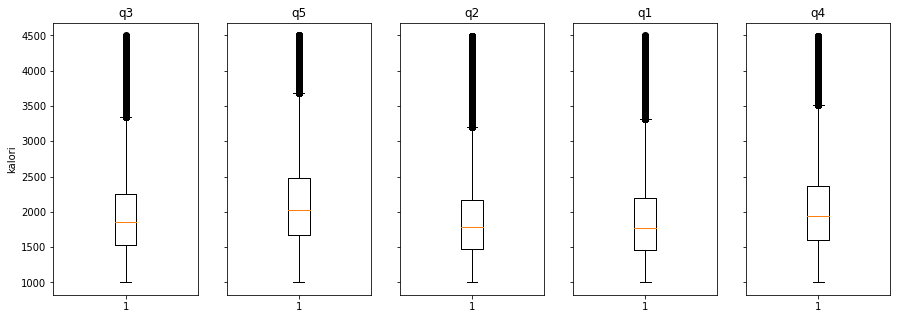

In [26]:
group = set(gizi_expend.q_expend.values)
ncols= 5
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5), sharey=True)
for (key, ax) in zip(group, axes.flatten()):
    ax.boxplot(gizi_expend.loc[gizi_expend.q_expend == key, 'kalori'])
    ax.set_title(key)
    if ax == axes[0]:
        ax.set_ylabel('kalori')
plt.show()



#### outlier protein per quantile pengeluaran 

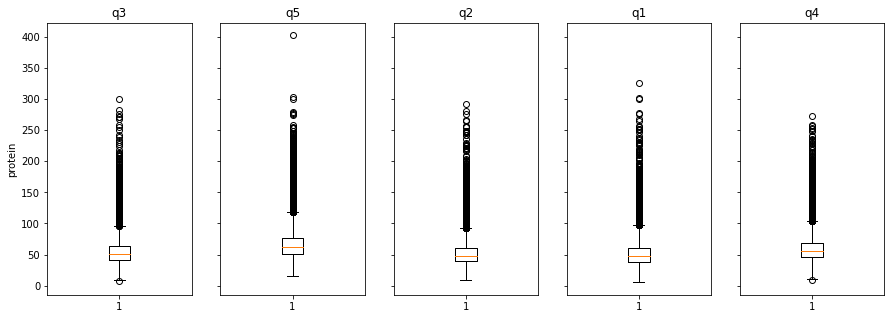

In [27]:
group = set(gizi_expend.q_expend.values)
ncols= 5
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5), sharey=True)
for (key, ax) in zip(group, axes.flatten()):
    ax.boxplot(gizi_expend.loc[gizi_expend.q_expend == key, 'protein'])
    ax.set_title(key)
    if ax == axes[0]:
        ax.set_ylabel('protein')
plt.show()



#### outlier lemak per quantile pengeluaran 

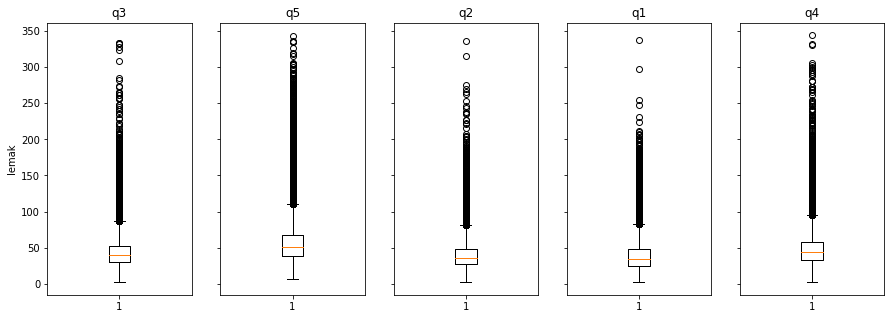

In [28]:
group = set(gizi_expend.q_expend.values)
ncols= 5
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5), sharey=True)
for (key, ax) in zip(group, axes.flatten()):
    ax.boxplot(gizi_expend.loc[gizi_expend.q_expend == key, 'lemak'])
    ax.set_title(key)
    if ax == axes[0]:
        ax.set_ylabel('lemak')
plt.show()



Terlihat bahwa untuk setiap kelompok quantile pengeluaran untuk setiap jenis gizi protein, lemak, dan kalori, masih teradapat outlier. Seperti pada bagian sebelumnya, penulis memutuskan untuk membiarkan nilai outlier ini tetap berada di dalam data tanpa ada *treatment* data apapun

### Rata-Rata AKG tingkat nasional

Perhitungan rata-rata konsumsi tiap indikator gizi secara nasional

In [29]:
# Creating Lambda Function for Weighted Average and Weighted Sum
wt_mean = lambda x: np.average(x, weights=df_sliced.loc[x.index, "WERT"])
wt_sum = lambda x: np.sum(x, weights=df_sliced.loc[x.index, "WERT"])

# hitung rata-rata dengan mempertimbangkan weight rumah tangga
# AKG per kapita untuk tiap rumah tangga berbeda bobotnya sehingga perlu diperhitungkan juga
# weight tiap rumah tangga

AKG_weighted = gizi_grouped_daily.apply(lambda x: np.average(x, weights=gizi_grouped_daily.loc[x.index, "WERT"])
                                         if x.name in indikator else x, axis=0)[indikator].mean()

In [30]:
AKG_weighted

kalori         1858.036745
protein          53.612277
lemak            43.534397
karbohidrat     285.826488
dtype: float64

bagaimana jika dihitung tanpa weight?

In [31]:
kalori_mean = gizi_grouped_daily['kalori'].mean()
kalori_mean

1981.5117227645228

# ANGKA KECUKUPAN GIZI MENURUT PERATURAN MENTERI KESEHATAN

Menurut permenkes nomor 75 tahun 2013 , angka kecukupan kalori dan protein yang direkomendasikan , secara rata-rata, untuk tiap penduduk adalah <b>2150 kilo kalori</b> dan <b>57 gram protein</b> setiap harinya <br>

Sedangkan untuk lemak dan karbohidrat, sesuai permenkes nomor 30 tahun 2013 konsumsi lemak agar <b> tidak lebih dari 67 gram per orang per hari </b> untuk mengurangi resiko penyakit seperti hipertensi, stroke dan diabetes serta serangan jantung, dan menurut Peraturan Menteri Kesehatan (PMK) nomor 41 tahun 2014 , dianjurkan konsumsi lemak per kapita  adalah <b> 25 % dari total kalori atau setara dengan 47 gram lemak </b> setiap harinya

#### proporsi penduduk (semua golongan usia) yang asupan kalorinya melebihi dari batas 2150


In [32]:
iseng = gizi_grouped_daily.loc[gizi_grouped_daily['kalori'] > 2150 ]
iseng

,URUT,kalori,protein,lemak,karbohidrat,WERT,WEIND,jumlah_art
2,110112500101603,2593.590357,75.092464,69.346250,385.179429,80.025658,20.006414,4
5,110112500101606,2656.173810,73.363429,51.778476,449.606762,99.981869,33.327290,3
7,110112500101608,3870.270000,77.797429,88.462429,651.617857,41.333202,41.333202,1
21,110112500202402,3464.985714,97.488571,122.906000,489.272857,57.332432,57.332432,1
23,110112500202404,2552.896429,91.722857,74.062857,301.896429,110.368240,55.184120,2
...,...,...,...,...,...,...,...,...
286099,947122000902604,2261.932679,53.560857,29.290500,449.465464,133.283096,33.320774,4
286101,947122000902606,2700.421786,66.582000,32.610679,535.479250,137.341583,68.670792,2
286102,947122000902607,3162.252500,110.765357,83.525214,432.047286,12.000000,6.000000,2
286105,947122000902610,3860.236750,109.621068,111.982850,542.083382,802.716919,200.679230,4


In [33]:
# proporsi penduduk, secara nasional yang asupan kalorinya telah memenuhi batas dari kemenkes
#(asumsi yang digunakan adalah weighting setiap individu dalam satu rumah tangga dianggap 
# setara sehingga konsumsi kalorinya sama , terlepas dari usia,jenis kelamin maupun faktor lainnya)

int(iseng['WEIND'].sum())/int(gizi_grouped_daily['WEIND'].sum()) * 100

29.839920840344025

#### proporsi penduduk (semua golongan usia) yang tingkat asupan proteinnya telah memenuhi angka 57 gram per harinya


In [34]:
iseng2 = gizi_grouped_daily.loc[gizi_grouped_daily['protein'] > 57 ]

In [35]:
# proporsi penduduk, secara nasional yang asupan kalorinya telah memenuhi batas dari kemenkes
#(asumsi yang digunakan adalah weighting setiap individu dalam satu rumah tangga dianggap 
# setara sehingga konsumsi kalorinya sama , terlepas dari usia,jenis kelamin maupun faktor lainnya)

int(iseng2['WEIND'].sum())/int(gizi_grouped_daily['WEIND'].sum()) * 100

39.86623609270082

### Secara nasional, hanya sekitar 30 % dari seluruh penduduk Indonesia telah terpenuhi asupan kalorinya, sementara tingkat asupan protein cenderung lebih baik yaitu di angka ~40% 

In [36]:
# sekarang coba kita lihat proporsi penduduk dengan konsumsi lemak di luar batas anjuran (47 - 67 g per hari)
lemak = gizi_grouped_daily.loc[ (gizi_grouped_daily['lemak'] >= 47) & (gizi_grouped_daily['lemak'] <= 67)  ]
int(lemak['WEIND'].sum())/int(gizi_grouped_daily['WEIND'].sum()) * 100


24.7735815327332

### Untuk angka kecukupan lemak baru sekitar 1/4 dari penduduk Indonesia yang berada di batas anjuran 47 - 67 gram lemak per harinya, atau dengan kata lain masih ada 75 % penduduk yang konsumsi lemaknya melebihi batas atau pun masih kurang dari anjuran pemerintah

# 2. Distribusi per daerah dan kota/desa serta tingkat pendapatan 

### A. Cek apakah data RT bisa di collapse ke level kabupaten/kota maupun provinsi

In [37]:
# cek jumlah data rt di dataset akg harian
jumlah_data = '{0:,}'.format(len(set(gizi_grouped_daily.URUT)))
jumlah_data

'286,113'

In [38]:
# 200000 ribu rumah tangga unique, jika merujuk ke slide presentasi maka representatif hingga tingkat kabupaten/kota
# sekarang ambil informasi provinsi (B1R1) dan kabupaten (B1R2) dan group by untuk tiap rumah tangga 
# dari dataset awal sus12_kons_gizi
daerah_gizi = sus12_kons_gizi.groupby('URUT')[['B1R1','B1R2']].max().reset_index()

# Buat identifikasi untuk daerah tiap RT
daerah_gizi=daerah_gizi.assign(kode_kabupaten=daerah_gizi['B1R1']*100+daerah_gizi['B1R2'])\
            .rename(columns={'B1R1':'kode_prov'}).drop(['B1R2'], axis=1)

# gabung ke data akg harian
gizi_grouped_daily_prov = gizi_grouped_daily.merge(daerah_gizi, left_on='URUT', right_on='URUT')
gizi_grouped_daily_prov.head()

,URUT,kalori,protein,lemak,karbohidrat,WERT,WEIND,jumlah_art,kode_prov,kode_kabupaten
0,110112500101601,1277.633929,37.238643,22.204750,216.257571,183.505020,45.876255,4,11,1101
1,110112500101602,1793.693929,49.248857,37.862571,282.291964,221.008743,55.252186,4,11,1101
2,110112500101603,2593.590357,75.092464,69.346250,385.179429,80.025658,20.006414,4,11,1101
3,110112500101604,1430.819048,39.622619,24.161190,252.797857,254.390213,42.398369,6,11,1101
4,110112500101605,1482.632143,45.375000,32.915893,228.803750,173.681061,43.420265,4,11,1101


### B. Ambil data kabupaten kota dari file excel untuk nama kabupaten/kota

#### Tambahkan nama provinsi

In [39]:
# biar lebih lengkap ambil data nama provinsi dan kabupaten kota
## untuk provinsi dari file pov_line di susenas13, untuk kabupaten kota dari layout modul gabungan susenas12
nama_provinsi = pd.read_csv("./susenas13/pov_line.csv", usecols = ['b1r1','nama_prov'])\
                .drop_duplicates().reset_index(drop=True)

# gabung ke data akg harian
gizi_grouped_daily_prov_name = gizi_grouped_daily_prov.merge(nama_provinsi, left_on='kode_prov', right_on='b1r1')
gizi_grouped_daily_prov_name.head()

,URUT,kalori,protein,lemak,karbohidrat,WERT,WEIND,jumlah_art,kode_prov,kode_kabupaten,b1r1,nama_prov
0,110112500101601,1277.633929,37.238643,22.204750,216.257571,183.505020,45.876255,4,11,1101,11,Aceh
1,110112500101602,1793.693929,49.248857,37.862571,282.291964,221.008743,55.252186,4,11,1101,11,Aceh
2,110112500101603,2593.590357,75.092464,69.346250,385.179429,80.025658,20.006414,4,11,1101,11,Aceh
3,110112500101604,1430.819048,39.622619,24.161190,252.797857,254.390213,42.398369,6,11,1101,11,Aceh
4,110112500101605,1482.632143,45.375000,32.915893,228.803750,173.681061,43.420265,4,11,1101,11,Aceh


#### Tambahkan nama kabupaten kota

In [40]:
## ambil data nama kabupaten kota dari file layout susesnas , sheet label
nama_kabupatenkota_raw = pd.read_excel("./susenas12/Layout -- Susenas 2012 Modul Gabungan.xls", sheet_name='LABEL')
## gunakan kolom value sebagai index , dengan cara fillna dan ambil yang valuenya =  KABU
nama_kabupatenkota_raw['Value'] = nama_kabupatenkota_raw['Value'].fillna(method='ffill')
nama_kabupatenkota = nama_kabupatenkota_raw.set_index('Value').loc['KABU']

# cleansing nama kabupaten kotanya agar lebih rapi dengan remove angka di depan nama kabupaten/kota
nama_kabupatenkota['Label'] = nama_kabupatenkota['Label'].apply(lambda x: x.split(".")[1].strip())
nama_kabupatenkota.head()

# gabung ke data akg harian
gizi_grouped_daily_daerah = gizi_grouped_daily_prov_name.merge(nama_kabupatenkota, 
                                                               left_on='kode_kabupaten', right_on='KODE')
gizi_grouped_daily_daerah = gizi_grouped_daily_daerah.drop(columns=['kode_prov','kode_kabupaten','b1r1','KODE'])
gizi_grouped_daily_daerah.tail()

,URUT,kalori,protein,lemak,karbohidrat,WERT,WEIND,jumlah_art,nama_prov,Label
286108,947122001103806,1381.880000,58.206514,51.578286,178.733429,2190.646820,438.129364,5,Papua,Jayapura
286109,947122001103807,1970.742286,90.243714,73.338057,205.930114,1605.079956,321.015991,5,Papua,Jayapura
286110,947122001103808,2165.612857,98.327143,71.332286,280.153143,649.540222,324.770111,2,Papua,Jayapura
286111,947122001103809,1765.710204,52.837755,44.304082,277.946531,98.785879,14.112268,7,Papua,Jayapura
286112,947122001103810,1573.511905,49.879524,34.153810,248.884048,36.000000,6.000000,6,Papua,Jayapura


### C. Lakukan Aggregasi ke tingkat provinsi --> kabupaten/kota

#### Aggregasi tingkat provinsi 

Pertama kita akan melakukan aggregasi ke tingkat provinsi untuk mengetahui bagaimana distribusi AKG di tiap daerah

In [41]:
# Creating Lambda Function for Weighted Average and Weighted Sum
wt_mean = lambda x: np.average(x, weights=gizi_grouped_daily_daerah.loc[x.index, "WERT"])
wt_sum = lambda x: np.sum(x, weights=gizi_grouped_daily_daerah.loc[x.index, "WERT"])


gizi_provinsi = gizi_grouped_daily_daerah.groupby('nama_prov').agg(kalori = ('kalori', wt_mean),
                                                     protein = ('protein', wt_mean),
                                                     lemak = ('lemak', wt_mean),
                                                     karbohidrat = ('karbohidrat', wt_mean),
#                                                      WEIND = ('WEIND', 'mean')
                                                     WERT = ('WERT', 'sum'))
gizi_provinsi

,kalori,protein,lemak,karbohidrat,WERT
nama_prov,,,,,
Aceh,1860.684230,53.107266,40.606383,294.473860,4.715497e+06
Bali,2034.548725,60.271331,47.326485,315.157327,4.069472e+06
Bangka Belitung,1783.411711,54.574750,39.940991,274.139673,1.302880e+06
Banten,1952.996010,58.715155,46.878960,289.858351,1.124157e+07
Bengkulu,1859.661702,51.543809,41.186873,293.716433,1.772938e+06
DI Yogyakarta,1849.353086,54.419292,47.531534,281.049193,3.530860e+06
DKI Jakarta,1922.298070,61.751251,61.607270,238.655877,9.881391e+06
Gorontalo,1752.228858,48.025248,37.722581,275.082731,1.087665e+06
Jambi,1857.249074,51.302046,42.854140,281.212475,3.254562e+06


### D. Provinsi mana saja yang secara rata-rata sudah terpenuhi konsumsi protein, kalori, maupun konsumsi lemaknya masih dalam batas normal?

In [42]:
def top_ten_akg(dataset,akg : str, batas_akg: int):
    urut_data = dataset.sort_values(by = akg, ascending = False)
    top_ten = urut_data.loc[urut_data[akg] > batas_akg ,akg].head(10).index
    return top_ten

In [43]:
print("Provinsi dengan kecukupan {0} terpenuhi : {1}".format('kalori'
                                                                ,list(top_ten_akg(gizi_provinsi,'kalori',2150))))
print("Provinsi dengan kecukupan {0} terpenuhi : {1}".format('protein',
                                                                list(top_ten_akg(gizi_provinsi,'protein',57))))
print("Provinsi dengan konsumsi {0} diatas anjuran : {1}".format('lemak',
                                                                list(top_ten_akg(gizi_provinsi,'lemak',67))))

Provinsi dengan kecukupan kalori terpenuhi : []
Provinsi dengan kecukupan protein terpenuhi : ['DKI Jakarta', 'Bali', 'Banten', 'Nusa Tenggara Barat', 'Kalimantan Selatan', 'Kepulauan Riau']
Provinsi dengan konsumsi lemak diatas anjuran : []


In [44]:
gizi_provinsi.sort_values(by='kalori',ascending=False)

,kalori,protein,lemak,karbohidrat,WERT
nama_prov,,,,,
Nusa Tenggara Barat,2036.879448,58.624199,39.149692,338.312634,4.601531e+06
Bali,2034.548725,60.271331,47.326485,315.157327,4.069472e+06
Kalimantan Selatan,1980.835020,57.951040,48.295090,296.552238,3.770838e+06
Sumatera Barat,1965.409867,53.267926,48.569045,294.613193,4.986544e+06
Banten,1952.996010,58.715155,46.878960,289.858351,1.124157e+07
Sulawesi Utara,1927.751961,56.214758,46.260434,298.437608,2.328751e+06
Sulawesi Selatan,1924.672130,56.750573,40.973954,315.807127,8.220676e+06
DKI Jakarta,1922.298070,61.751251,61.607270,238.655877,9.881391e+06
Sulawesi Barat,1909.576345,54.574027,39.442557,326.348019,1.222235e+06


Menarik untuk dilihat bahwa jika kita melihat secara per individu/rumah tangga , maka proporsi penduduk yang AKG nya terpenuhi cukup banyak , namun jika kita aggregasi ke tingkat provinsi, hal yang berbeda terjadi dan justru tidak ada satupun provinsi yang kebutuhan kalorinya terpenuhi , sementara untuk kecukupan protein hanya terjadi di 6 provinsi saja. Menariknya lagi, khusus untuk kalori, jika kita urutkan dari konsumsi kalori terbesar hingga terendah, maka provinsi yang rata2 jumlah kalorinya bahkan menembus angka 2000 kilo kalori per kapita hanya bali dan NTB

### Quick visualisation 

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [46]:
# import geojson data

json_path = "./geopandas_INA.json"
df_geom = gpd.read_file(json_path)
df_geom.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,IDN,Indonesia,IDN.1_1,Aceh,,,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1..."
1,IDN,Indonesia,IDN.2_1,Bali,,,Propinisi,Province,51,ID.BA,"MULTIPOLYGON (((115.59464 -8.81672, 115.59444 ..."
2,IDN,Indonesia,IDN.3_1,Bangka Belitung,,,Propinisi,Province,19,ID.BB,"MULTIPOLYGON (((107.96173 -3.41100, 107.96220 ..."
3,IDN,Indonesia,IDN.4_1,Banten,,,Propinisi,Province,36,ID.BT,"MULTIPOLYGON (((105.54977 -6.99566, 105.55035 ..."
4,IDN,Indonesia,IDN.5_1,Bengkulu,,,Propinisi,Province,17,ID.BE,"MULTIPOLYGON (((102.37586 -5.36968, 102.38067 ..."


### Cleaning up data

Data geojsonnya ada pada level provinsi , pastikan dulu kalau nama provinsinya sudah sesuai dengan data gizi_provinsi.Kalau engga, ya disesuaikan.

In [47]:
# cek perbedaan nama antara provinsi di data gizi_provinsi dengan data df_geom

province_diff = set(gizi_provinsi.index).difference(set(df_geom.NAME_1))
province_diff

{'DI Yogyakarta', 'DKI Jakarta'}

In [48]:
# ternyata nama provinsi yogyakarta dan dki jakarta berbeda antar kedua dataset.
# untuk kasus ini kita ganti namanya di dataset df_geom aja

prov_dict = {key : value for key, value in (zip(("Jakarta Raya", "Yogyakarta"), province_diff))}

df_geom.loc[df_geom.NAME_1.isin(prov_dict.keys()), 'NAME_1'] = df_geom['NAME_1'].map(prov_dict)
df_geom.tail()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
28,IDN,Indonesia,IDN.29_1,Sulawesi Utara,,,Propinisi,Province,71,ID.SW,"MULTIPOLYGON (((124.48003 0.44948, 124.48026 0..."
29,IDN,Indonesia,IDN.30_1,Sumatera Barat,,,Propinisi,Province,13,ID.SB,"MULTIPOLYGON (((100.56964 -3.27509, 100.56933 ..."
30,IDN,Indonesia,IDN.31_1,Sumatera Selatan,,,Propinisi,Province,16,ID.SL,"MULTIPOLYGON (((106.16177 -3.29708, 106.16225 ..."
31,IDN,Indonesia,IDN.32_1,Sumatera Utara,,,Propinisi,Province,12,ID.SU,"MULTIPOLYGON (((98.50178 -0.59472, 98.50178 -0..."
32,IDN,Indonesia,IDN.33_1,DKI Jakarta,,,Propinisi,Province,34,ID.YO,"MULTIPOLYGON (((110.66244 -8.17778, 110.66234 ..."


In [49]:
# looking good. Sekarang kita merge ke dataframe gizi_provinsi

gizi_prov_geom = df_geom.merge(gizi_provinsi , how='inner', left_on="NAME_1", right_on=gizi_provinsi.index)
gizi_prov_geom.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,kalori,protein,lemak,karbohidrat,WERT
0,IDN,Indonesia,IDN.1_1,Aceh,,,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1...",1860.684230,53.107266,40.606383,294.473860,4.715497e+06
1,IDN,Indonesia,IDN.2_1,Bali,,,Propinisi,Province,51,ID.BA,"MULTIPOLYGON (((115.59464 -8.81672, 115.59444 ...",2034.548725,60.271331,47.326485,315.157327,4.069472e+06
2,IDN,Indonesia,IDN.3_1,Bangka Belitung,,,Propinisi,Province,19,ID.BB,"MULTIPOLYGON (((107.96173 -3.41100, 107.96220 ...",1783.411711,54.574750,39.940991,274.139673,1.302880e+06
3,IDN,Indonesia,IDN.4_1,Banten,,,Propinisi,Province,36,ID.BT,"MULTIPOLYGON (((105.54977 -6.99566, 105.55035 ...",1952.996010,58.715155,46.878960,289.858351,1.124157e+07
4,IDN,Indonesia,IDN.5_1,Bengkulu,,,Propinisi,Province,17,ID.BE,"MULTIPOLYGON (((102.37586 -5.36968, 102.38067 ...",1859.661702,51.543809,41.186873,293.716433,1.772938e+06


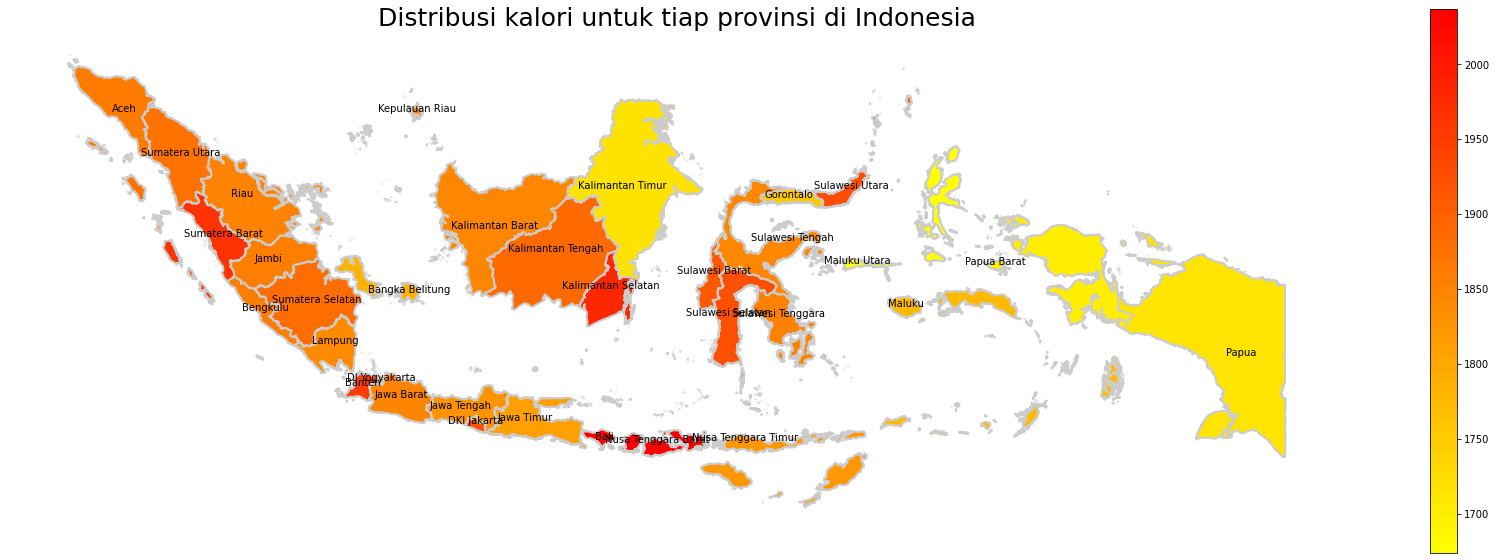

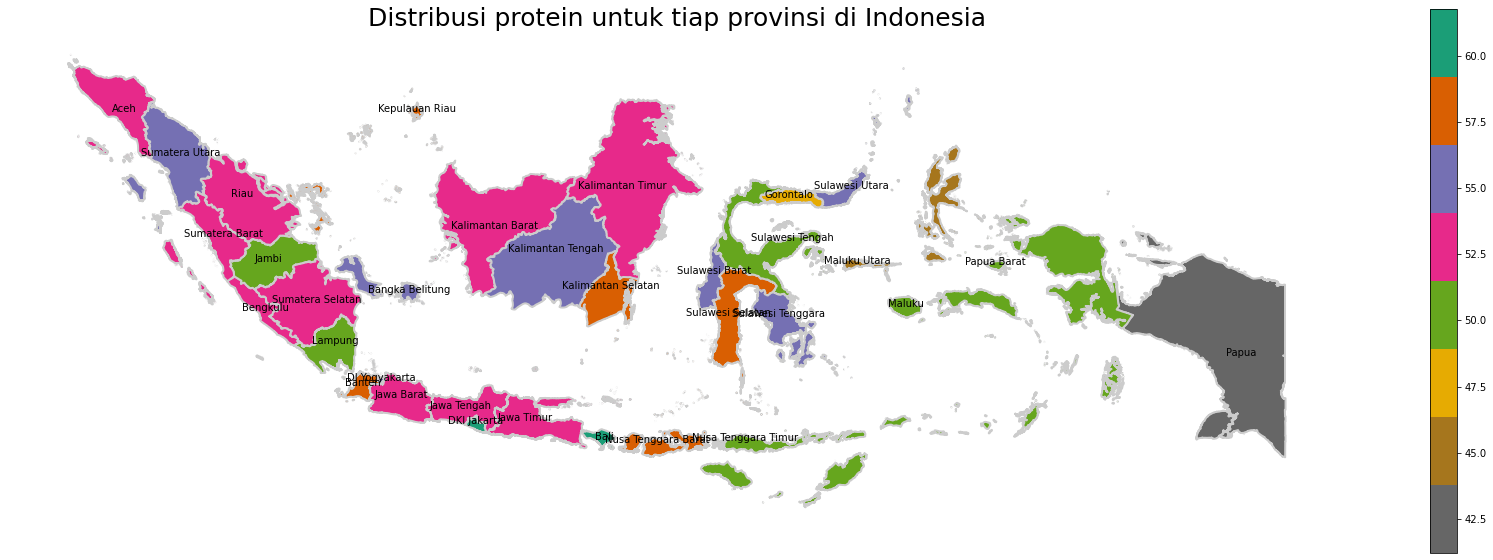

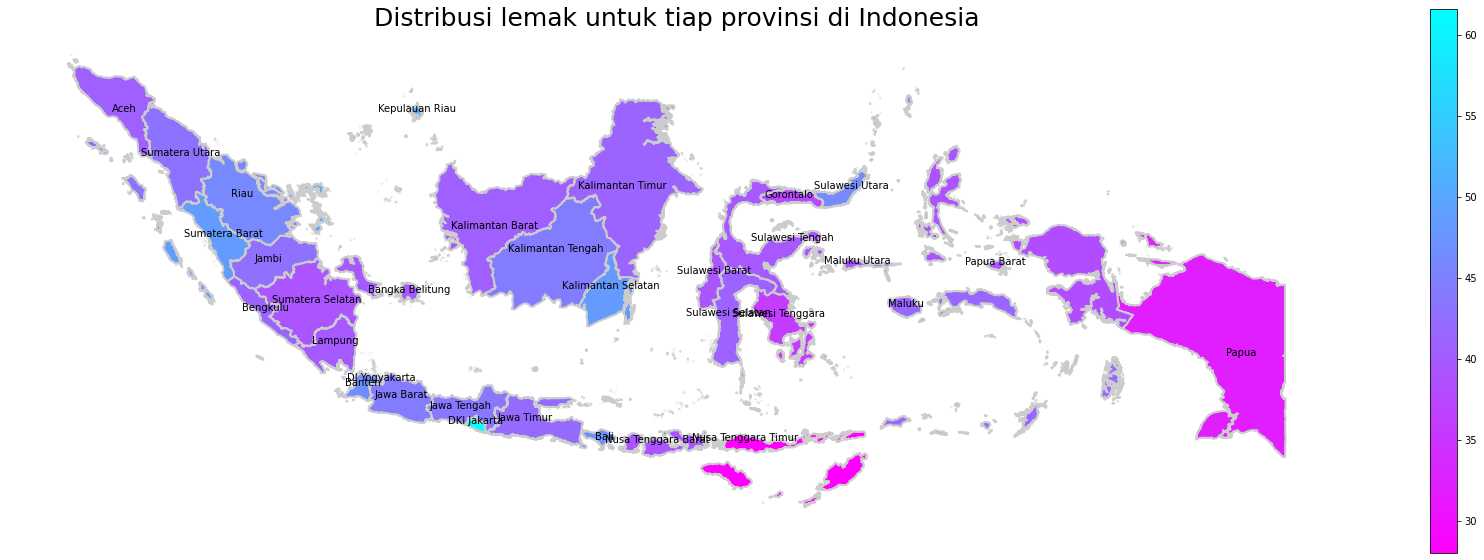

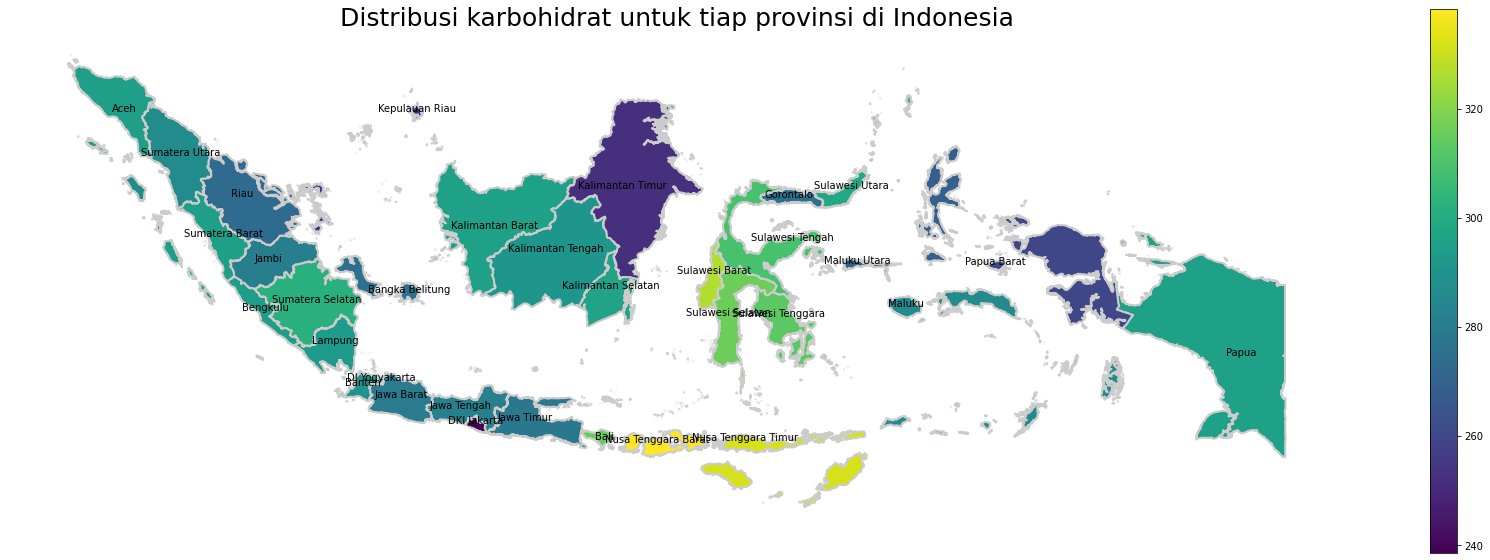

In [50]:
# start visualizing!
list_color = ['autumn_r','Dark2_r','cool_r','viridis']

for n,col in enumerate(cek_gizi.columns):
    fig, ax = plt.subplots(1, figsize=(30, 10))
    ax.axis('off')
    title = 'Distribusi {0} untuk tiap provinsi di Indonesia'.format(col)
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    gizi_prov_geom.plot(column= col, cmap=list_color[n], linewidth=2, ax=ax, 
                        edgecolor='0.8', legend=True)

    gizi_prov_geom['coords'] = gizi_prov_geom['geometry'].apply(lambda x: x.representative_point().coords[:])
    gizi_prov_geom['coords'] = [coords[0] for coords in gizi_prov_geom['coords']]
    for idx, row in gizi_prov_geom.iterrows():
        plt.annotate(text=row['NAME_1'], xy=row['coords'],horizontalalignment='center')


In [51]:
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

### D. Cek berdasarkan klasifikasi desa/kota

Untuk klasifikasi desa/kota (urban rural), maka kita merge dataframe gizi rumah tanggga dengan data susenas kor rumah tangga tahun 2012 

In [52]:
gizi_urban_rural = pd.merge(gizi_grouped_daily_daerah, sus12_rt[['URUT', 'B1R5']], on='URUT').rename(
    columns ={"B1R5":"desa_kota"})

#### Bagaimana rata-rata per kota atau desa? 

In [53]:
# Creating Lambda Function for Weighted Average and Weighted Sum
wt_mean = lambda x: np.average(x, weights=gizi_grouped_daily_daerah.loc[x.index, "WERT"])
wt_sum = lambda x: np.sum(x, weights=gizi_grouped_daily_daerah.loc[x.index, "WERT"])

cek_desa_kota = gizi_urban_rural.groupby('desa_kota').agg(kalori = ('kalori', wt_mean),
                                                     protein = ('protein', wt_mean),
                                                     lemak = ('lemak', wt_mean),
                                                     karbohidrat = ('karbohidrat', wt_mean)).reset_index()

In [54]:
# gabung dan bandingkan dengan data akg secara nasional 
akg_nasional = pd.DataFrame(AKG_weighted).transpose().assign(desa_kota = 0)
cek_desa_kota = pd.concat([akg_nasional, cek_desa_kota], ignore_index=True)
cek_desa_kota['desa_kota'] = cek_desa_kota['desa_kota'].map({0 : "nasional", 1: "kota", 2:"desa"})
cek_desa_kota

,kalori,protein,lemak,karbohidrat,desa_kota
0,1858.036745,53.612277,43.534397,285.826488,nasional
1,1829.915745,55.183853,47.053936,265.369888,kota
2,1886.189837,52.038908,40.010841,306.306433,desa


Dari sini dapat dilihat bahwa konsumsi kalori untuk masyarakat perkotaan (~1830 kcal) justru lebih rendah dibandingkan dengan tingkat pedesaan (1886 kcal). Jika kita perhatikan juga dari tingkat konsumsi karbohidrat penduduk pedesaan mengkonsumsi jauh lebih banyak karbohidrat secara rata-rata dibandingkan penduduk perkotaan. Kita dapat membuat hipotesa bahwa pola konsumsi penduduk pedesaan cenderung proporsi makanan sehari-hari didominasi makanan pokok tinggi karbohidrat (nasi atau pengganti nasi), mendorong tingkat kalori yang jauh lebih tinggi juga 
<br><br>Adapun untuk konsumsi protein dan lemak, penduduk urban konsumsinya lebih tinggi dibandingkan dengan penduduk pedesaan (55 dan 47 g berbanding 52 dan 40 g). Dengan kata lain bisa kita simpulkan bahwa penduduk perkotaan cenderung memiliki pola makan yang rendah karbohidrat namun tinggi protein dan lemak.

#### mari kita buat visualisasi sederhana dari tabel di atas 

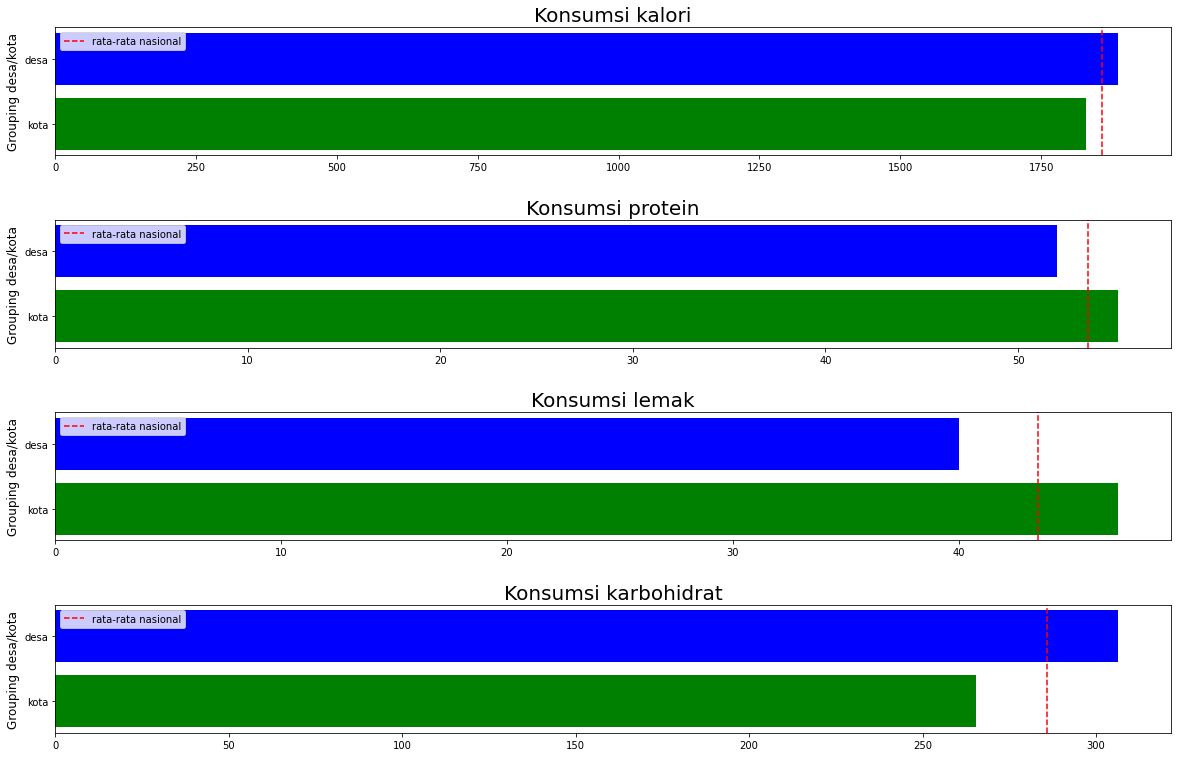

In [55]:
fig, axes = plt.subplots(4,1, figsize=(20,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4) # beri space antar row

for (key, ax) in zip(cek_desa_kota.columns, axes.flatten()):
    ax.barh(cek_desa_kota.desa_kota[1:3], cek_desa_kota.loc[1:3,key], color =['g','b'])
    ax.axvline(cek_desa_kota.loc[0,key], color = 'r', linestyle = "--", label = 'rata-rata nasional')
    ax.set_title("Konsumsi {0}".format(key), size = 20)
    ax.set_ylabel("Grouping desa/kota", size = 12)
    ax.legend(loc=2)

plt.show()


### E. Cek seberapa mendekati data di provinsi untuk kalori dan protein terhadap threshold (kalori = 2150, protein = 57  ). Untuk kebutuhan lemak diambil anjuran pemerintah yaitu 25% dari kalori atau 47 gram

Simple approach dengan menggunakan eucledian distance based similiarity untuk mengukur seberapa dekat data rata-rata kalori dan protein sebuah provinsi terhadap ambang batas rekomendasi AKG dari kemenkes.
<br>
Eucledian distance adalah jarak antar dua vektor mengikuti rumus : .... 
Distance based similiarity adalah 1 - eucledian distance



In [56]:
# pertama set vector thresholdnya

threshold = np.array([2150, 57, 47])

# kita normalise dulu nilai per variabel, karena perhitungan dot product dari vektor akan 
# dipengaruhi oleh skala tiap vektor. Dalam hal ini, order of magnitude kalori adalah 100 kali 
# protein dan lemak sehingga perlu dinormalisasi

# kita akan gunakan metode normalisasi sederhana min max scaler dari sklearn
dist_vect = gizi_provinsi[['kalori', 'protein', 'lemak']].to_numpy() # ubah ketiga variabel menjadi vektor 2 dimensi
dist_vect = np.append(dist_vect, [threshold], axis = 0) # append vektor threhsold untuk di normalisasi

# gunakan minmax scaler
from sklearn import preprocessing
min_max = preprocessing.MinMaxScaler()
dist_scaled = min_max.fit_transform(dist_vect)

# hitung eucledian similiarity
# for x in dist_scaled:
#     print(1/(1+np.linalg.norm(x - dist_scaled[-1])))
df_sim= pd.DataFrame(1/ (1 + np.linalg.norm(dist_scaled - dist_scaled[-1], axis = 1)), columns = ['similiarity'])

In [57]:
# selanjutnya kita gabungkan kembali ke data gizi provinsi
gizi_sim = pd.concat([gizi_provinsi.reset_index(), df_sim[:-1]], axis = 1).set_index('nama_prov')
gizi_prov_geom_sim = df_geom.merge(gizi_sim , how='inner', left_on="NAME_1", right_on=gizi_sim.index)
gizi_prov_geom_sim.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,kalori,protein,lemak,karbohidrat,WERT,similiarity
0,IDN,Indonesia,IDN.1_1,Aceh,,,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1...",1860.684230,53.107266,40.606383,294.473860,4.715497e+06,0.600718
1,IDN,Indonesia,IDN.2_1,Bali,,,Propinisi,Province,51,ID.BA,"MULTIPOLYGON (((115.59464 -8.81672, 115.59444 ...",2034.548725,60.271331,47.326485,315.157327,4.069472e+06,0.774950
2,IDN,Indonesia,IDN.3_1,Bangka Belitung,,,Propinisi,Province,19,ID.BB,"MULTIPOLYGON (((107.96173 -3.41100, 107.96220 ...",1783.411711,54.574750,39.940991,274.139673,1.302880e+06,0.553355
3,IDN,Indonesia,IDN.4_1,Banten,,,Propinisi,Province,36,ID.BT,"MULTIPOLYGON (((105.54977 -6.99566, 105.55035 ...",1952.996010,58.715155,46.878960,289.858351,1.124157e+07,0.703085
4,IDN,Indonesia,IDN.5_1,Bengkulu,,,Propinisi,Province,17,ID.BE,"MULTIPOLYGON (((102.37586 -5.36968, 102.38067 ...",1859.661702,51.543809,41.186873,293.716433,1.772938e+06,0.592555


In [58]:
# # from keplergl import KeplerGl
# map_1 = KeplerGl()
# map_1.add_data(data=gizi_prov_geom_sim)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [60]:
# map_1.save_to_html()

# 3. Distribusi individu (usia, jenis kelamin,tingkat pendidikan)

TBD

# 4. Analisis item makanan/minuman penyumbang AKG terbesar 

Cek harga pangan untuk tiap daerah : dari amount rupiah dibagi amount kilonya (cek ke data excel) kemudian dipetakan
Cek juga engel's law : pengeluaran untuk makanan apakah proporsinya berkurang dengan naikknya pendapatan

### A. Jumlah kalori, protein, lemak per kelompok makanan

pertama-tama kita buat dictionary untuk nama kelompok makanan berdasarkan variabel kode makanan food_code, dan gabungkan ke dataframe gizi weekly untuk memperjelas jumlah akg tiap kelompok makanan untuk setiap rumah tangga

In [14]:
# buat dictionary kode dan nama makanan
food_group_name = ["Padi-padian", "Umbi-umbian", "Ikan/udang/cumi", "Daging","Telur dan Susu", "Sayur-sayuran", 
              "Kacang-kacangan", "Buah-buahan", "Minyak dan Lemak", "Bahan Minuman", "Bumbu-bumbuan", 
              "Konsumsi Lainnya", "Makanan dan Minuman Jadi"]
food_group = dict(zip(food_code,food_group_name))

# buat kolom baru di dataframe gizi_weekly
gizi_weekly_named= gizi_weekly.copy()
gizi_weekly_named['grup_makanan'] = gizi_weekly_named['KODE'].map(food_group)

# coba kita cek datanya
gizi_weekly_named.head()

,URUT,B1R1,B1R2,B1R5,B1R8,B2R1,KODE,KLP,KALORI,PROTEIN,LEMAK,KARBO,WEIND,WERT,grup_makanan
0,110112500101601,11,1,1,1,4,1,0,21732.0,508.50,87.00,4653.000,45.876255,183.50502,Padi-padian
2,110112500101601,11,1,1,1,4,20,0,2269.0,369.30,77.04,0.900,45.876255,183.50502,Ikan/udang/cumi
6,110112500101601,11,1,1,1,4,71,0,685.3,55.18,48.06,3.115,45.876255,183.50502,Telur dan Susu
8,110112500101601,11,1,1,1,4,85,0,253.8,14.52,3.03,37.935,45.876255,183.50502,Sayur-sayuran
13,110112500101601,11,1,1,1,4,115,0,904.0,50.60,85.60,42.200,45.876255,183.50502,Kacang-kacangan


In [15]:
# looks like not all household consume each and every the food group stated before.
# coba kita cek kemunculan masing2 kelompok makanan dan jadikan dataframe
count_group_makanan = pd.DataFrame(gizi_weekly_named['grup_makanan'].value_counts()).rename(
    columns = {'grup_makanan':"Jumlah RT"})

num_rt = count_group_makanan['Jumlah RT'].max() # ambil jumlah rumah tangga maximum

Selanjutnya kita coba groupby berdasarkan kelompok makanannya

In [16]:
# tapi sebelumnya kita hitung dulu konsumsi per kapita untuk tiap kelompok makanan per rumah tangga
akg_columns = ['KALORI', 'PROTEIN', 'LEMAK', 'KARBO']
gizi_weekly_named[akg_columns] = gizi_weekly_named[akg_columns].transform(lambda x : x/7/gizi_weekly_named.B2R1)


# Creating Lambda Function for Weighted Average and Weighted Sum
wt_mean = lambda x: np.average(x, weights=gizi_weekly_named.loc[x.index, "WERT"])
wt_sum = lambda x: np.sum(x, weights=gizi_weekly_named.loc[x.index, "WERT"])


gizi_daily_named = gizi_weekly_named.groupby('grup_makanan').agg(kalori = ('KALORI', wt_mean),
                                                     protein = ('PROTEIN', wt_mean),
                                                     lemak = ('LEMAK', wt_mean),
                                                     karbohidrat = ('KARBO', wt_mean),
                                                     WEIND = ('WEIND', 'sum'),
                                                     WERT = ('WERT', 'sum')).reset_index()

In [17]:
# selanjutnya kita normalisasi nilai masing-masing variabel gizi untuk tiap grup makanan
# berdasarkan jumlah RT yang ada data tiap grup makanan 
grup_makanan_gizi = gizi_daily_named.set_index('grup_makanan')
grup_makanan_gizi = grup_makanan_gizi[['kalori', 'protein', 'lemak', 'karbohidrat']]\
            .apply(lambda x : x * count_group_makanan['Jumlah RT'] / num_rt).sort_values(by='kalori', ascending = False)
grup_makanan_gizi

,kalori,protein,lemak,karbohidrat
Padi-padian,896.629101,21.036433,3.662960,192.117224
Makanan dan Minuman Jadi,263.828262,7.939171,9.586441,34.291780
Minyak dan Lemak,245.332950,0.273312,15.303433,0.998335
Bahan Minuman,85.196053,0.860043,0.256159,21.539358
Daging,48.639173,2.712268,4.082958,0.101480
Konsumsi Lainnya,47.702112,0.967928,1.658713,7.001975
Kacang-kacangan,47.167268,4.498756,2.227827,2.899247
Telur dan Susu,47.038984,2.814201,2.545685,3.101189
Ikan/udang/cumi,46.612779,7.736391,1.300336,0.487844
Sayur-sayuran,38.301632,2.422003,0.649135,6.695867


In [98]:
# kita cek juga dalam bentuk persentase
grup_makanan_pct = grup_makanan_gizi.apply(lambda x : (x/ x.sum())* 100)
grup_makanan_pct

,kalori,protein,lemak,karbohidrat
Padi-padian,48.446279,40.022884,8.674439,66.761490
Makanan dan Minuman Jadi,14.255056,15.104678,22.702128,11.916528
Minyak dan Lemak,13.255725,0.519990,36.240821,0.346925
Bahan Minuman,4.603277,1.636276,0.606622,7.485012
Daging,2.628051,5.160228,9.669055,0.035265
Konsumsi Lainnya,2.577420,1.841533,3.928080,2.433214
Kacang-kacangan,2.548522,8.559113,5.275828,1.007500
Telur dan Susu,2.541590,5.354161,6.028562,1.077675
Ikan/udang/cumi,2.518562,14.718878,3.079391,0.169528
Sayur-sayuran,2.069497,4.607984,1.537248,2.326840


Dapat dilihat bahwa padi-padian (beras, gandum, dll) menjadi bahan makanan utama untuk penduduk Indonesia, dan menjadi penyumbang kalori, protein, serta karbohidrat terbesar. Sementara itu, makanan dan minuman jadi (termasuk di dalamnya makanan dan minuman cepat saji, gorengan , serta mi instan ) menjadi sumber gizi urutan kedua untuk kalori,protein serta karbohidrat. Hal ini menandakan masih banyak masyarakat yang memilih untuk mengkonsumsi makanan cepat saji dibandingkan menyiapkannya sendiri biarpun dari segi micronutrient (vitamin, kalsium, dll) kurang baik. Untuk sumber protein utama, selain didapat dari padi-padian dan makanan jadi, masyarakat Indonesia masih mengandalkan konsumsi Ikan dan makanan laut lainnya, sementara konsumsi daging hanya menyumbang sekitar 5 persen dari rata-rata konsumsi protein harian

### Visualisasi 

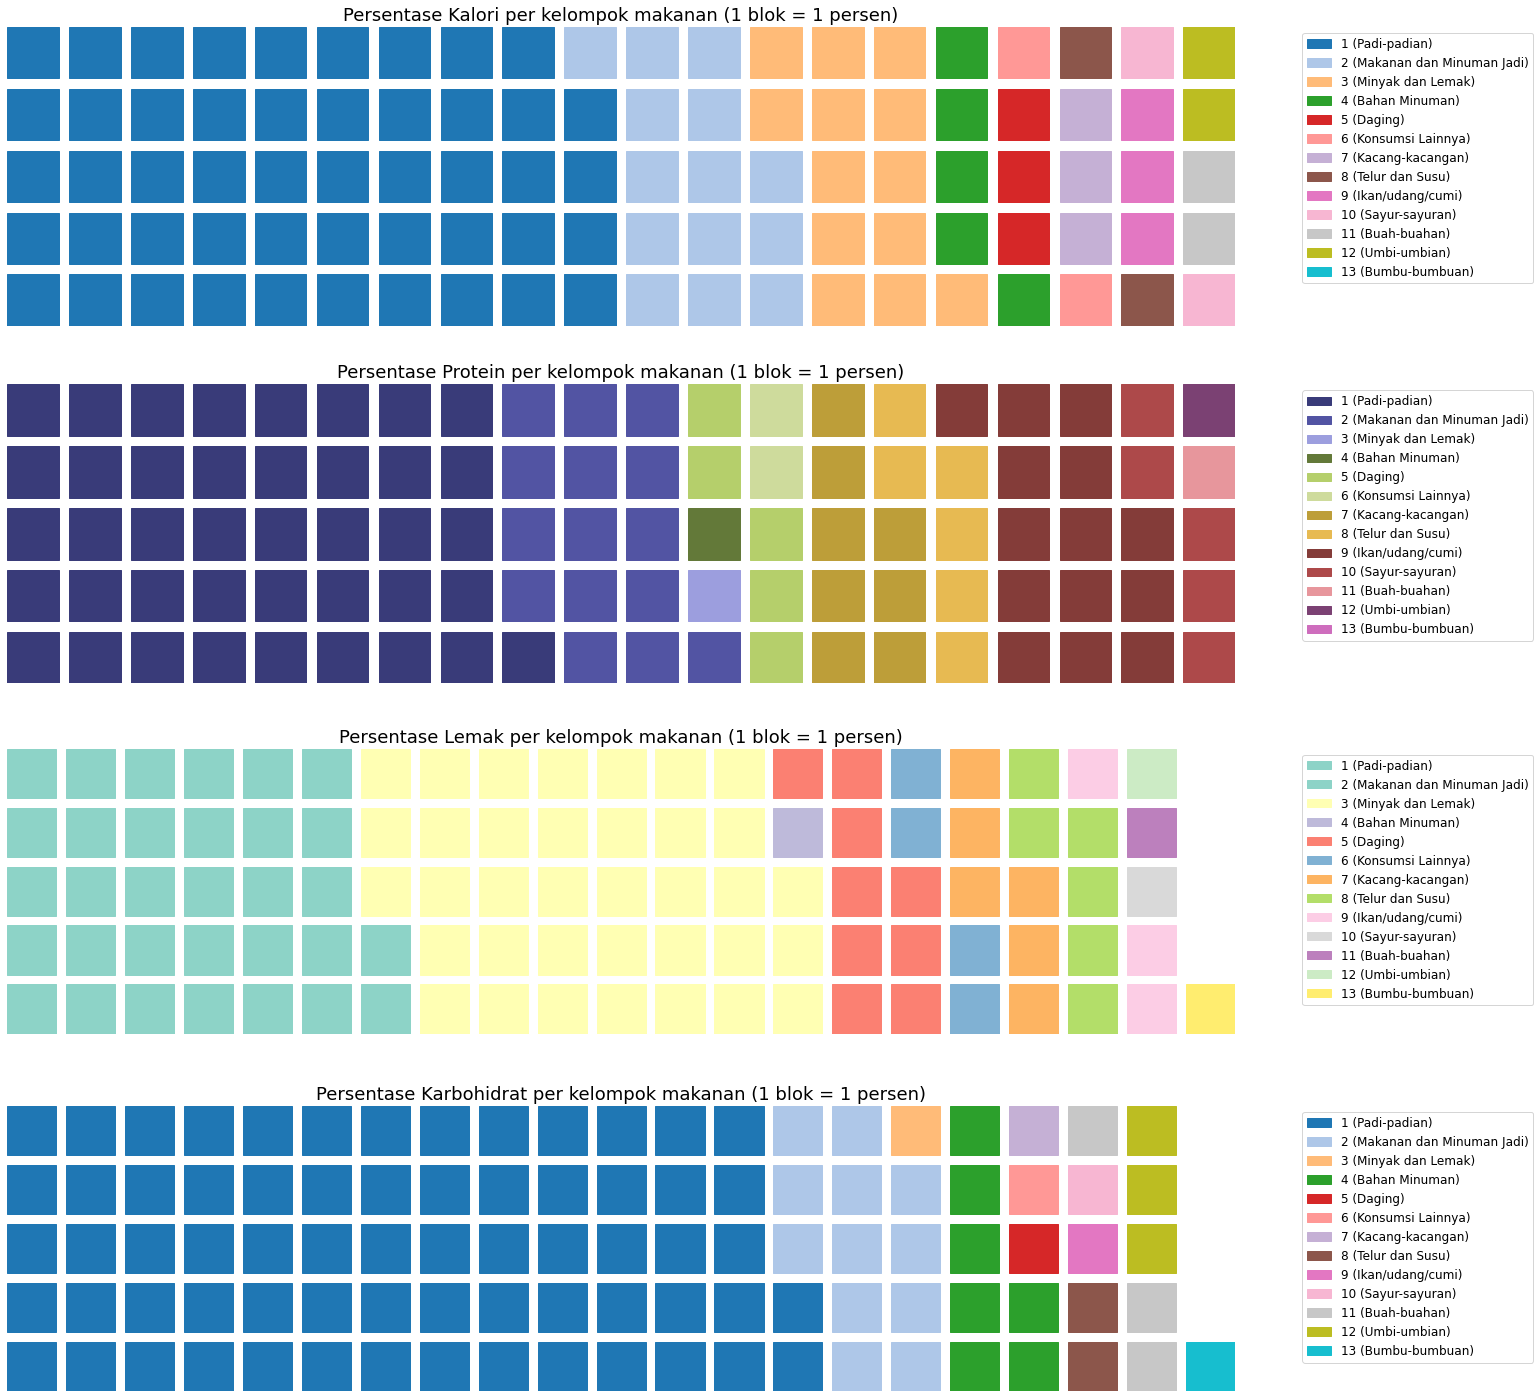

In [134]:
from pywaffle import Waffle

# Import
df_raw = grup_makanan_pct.copy()

# Prepare Data
df = df_raw.reset_index()
n_categories = df.shape[0]
colors_1 = [plt.cm.tab20(i/float(n_categories)) for i in range(n_categories)]
colors_2 = [plt.cm.tab20b(i/float(n_categories)) for i in range(n_categories)]
colors_3 = [plt.cm.tab20c(i/float(n_categories)) for i in range(n_categories)]
colors_4 = [plt.cm.Set3(i/float(n_categories)) for i in range(n_categories)]

# Draw Plot and Decorate
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '411': {
            'values': df['kalori'],
            'labels': ["{0} ({1})".format(n[0]+1, n[1]) for n in df[['index', 'kalori']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12},
            'title': {'label': 'Persentase Kalori per kelompok makanan (1 blok = 1 persen)', 'loc': 'center', 'fontsize':18},
            'colors' : colors
        },
        '412': {
            'values': df['protein'],
            'labels': ["{0} ({1})".format(n[0]+1, n[1]) for n in df[['index', 'protein']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12},
            'title': {'label': 'Persentase Protein per kelompok makanan (1 blok = 1 persen)', 'loc': 'center', 'fontsize':18},
            'colors' : colors_2
        },
        '413': {
            'values': df['lemak'],
            'labels': ["{0} ({1})".format(n[0]+1, n[1]) for n in df[['index', 'lemak']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12},
            'title': {'label': 'Persentase Lemak per kelompok makanan (1 blok = 1 persen)', 'loc': 'center', 'fontsize':18},
            'colors' : colors_4
        },
        '414': {
            'values': df['karbohidrat'],
            'labels': ["{0} ({1})".format(n[0]+1, n[1]) for n in df[['index', 'karbohidrat']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12},
            'title': {'label': 'Persentase Karbohidrat per kelompok makanan (1 blok = 1 persen)', 'loc': 'center', 'fontsize':18},
            'colors' : colors_1
        }
    },
    rows=5,
    figsize=(20, 20)
)

### B. Cek pola konsumsi setiap kelompok makanan berdasarkan klasifikasi kota/desa

Kita cek juga bagaimana pola konsumsi sesuai dengan kualifikasi kota dan desa. Kita lakukan langkah yang sama dengan bagian A, namun pertama kita filter dulu berdasarkan variabel B1R5 sebagai penanda kota/desa

In [209]:
# langkah di bagian a kita masukkan ke dalam sebuah fungsi untuk membantu persiapan data
# buat dictionary kode dan nama makanan
food_group_name = ["Padi-padian", "Umbi-umbian", "Ikan/udang/cumi", "Daging","Telur dan Susu", "Sayur-sayuran", 
              "Kacang-kacangan", "Buah-buahan", "Minyak dan Lemak", "Bahan Minuman", "Bumbu-bumbuan", 
              "Konsumsi Lainnya", "Makanan dan Minuman Jadi"]
food_group = dict(zip(food_code,food_group_name))

def buat_kelompok_makanan(data):
    # buat kolom baru di dataframe gizi_weekly
    data['grup_makanan'] = data['KODE'].map(food_group)
    
    count_makanan = pd.DataFrame(data['grup_makanan'].value_counts()).rename(columns = {'grup_makanan':"Jumlah RT"})
    num_rt = count_makanan['Jumlah RT'].max()
    
    # tapi sebelumnya kita hitung dulu konsumsi per kapita untuk tiap kelompok makanan per rumah tangga
    akg_columns = ['KALORI', 'PROTEIN', 'LEMAK', 'KARBO']
    data[akg_columns] = data[akg_columns].transform(lambda x : x/7/data.B2R1)

    # Creating Lambda Function for Weighted Average and Weighted Sum
    wt_mean = lambda x: np.average(x, weights=data.loc[x.index, "WERT"])
    wt_sum = lambda x: np.sum(x, weights=data.loc[x.index, "WERT"])

    data_daily = data.groupby('grup_makanan').agg(kalori = ('KALORI', wt_mean),
                                                         protein = ('PROTEIN', wt_mean),
                                                         lemak = ('LEMAK', wt_mean),
                                                         karbohidrat = ('KARBO', wt_mean),
                                                         WEIND = ('WEIND', 'sum'),
                                                         WERT = ('WERT', 'sum')).reset_index()
    
    grup_gizi = data_daily.set_index('grup_makanan')
    grup_gizi = grup_gizi[['kalori', 'protein', 'lemak', 'karbohidrat']]\
            .apply(lambda x : x * count_makanan['Jumlah RT'] / num_rt).sort_values(by='kalori', ascending = False)
    grup_gizi_pct= grup_gizi.apply(lambda x : (x/ x.sum())* 100)
    return grup_gizi, grup_gizi_pct


In [210]:
# konsumsi per kelompok makanan untuk klasifikasi kota
# ambil df kota dan desa 
df_kota = gizi_weekly.loc[gizi_weekly_named['B1R5'] == 1] 
df_desa = gizi_weekly.loc[gizi_weekly_named['B1R5'] == 2]

gizi_kota,gizi_kota_pct = buat_kelompok_makanan(df_kota)
gizi_desa,gizi_desa_pct = buat_kelompok_makanan(df_desa)

<ipython-input-209-30596893d5f1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grup_makanan'] = data['KODE'].map(food_group)
C:\Users\A\Anaconda3\envs\susenas\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [229]:
# gabungkan keduanya
gizi_kota_desa = pd.merge(gizi_kota, gizi_desa, left_on = gizi_kota.index, right_on=gizi_desa.index,
                         suffixes=('_kota', '_desa')).set_index('key_0')
gizi_kota_desa

,kalori_kota,protein_kota,lemak_kota,karbohidrat_kota,kalori_desa,protein_desa,lemak_desa,karbohidrat_desa
key_0,,,,,,,,
Padi-padian,799.258674,18.734790,3.205291,171.301367,978.319212,22.970191,4.056577,209.573316
Makanan dan Minuman Jadi,316.741171,10.209478,11.317505,40.666503,213.978119,5.807639,7.953497,28.280588
Minyak dan Lemak,249.993284,0.198926,14.785006,0.729006,235.210694,0.342313,15.488269,1.247973
Daging,73.385120,3.991988,6.189534,0.194788,26.728924,1.593393,2.213626,0.012957
Bahan Minuman,72.517225,0.645342,0.263711,18.293154,95.915610,1.053492,0.243492,24.289525
Telur dan Susu,57.694121,3.453847,3.089238,3.877627,37.165403,2.221432,2.042634,2.380286
Kacang-kacangan,55.811442,5.381895,2.561009,3.501344,39.358482,3.700727,1.927150,2.355050
Konsumsi Lainnya,53.061116,1.059746,1.704571,8.166464,42.300614,0.874623,1.606182,5.845221
Ikan/udang/cumi,43.644167,7.322430,1.191782,0.427450,48.522931,7.972953,1.379928,0.537804


### Visualisasi sederhana

Kita akan coba visualiasi perbandingan distribusi kalori dan protein per kelompok makanan untuk tiap klasifikasi kota dan desa

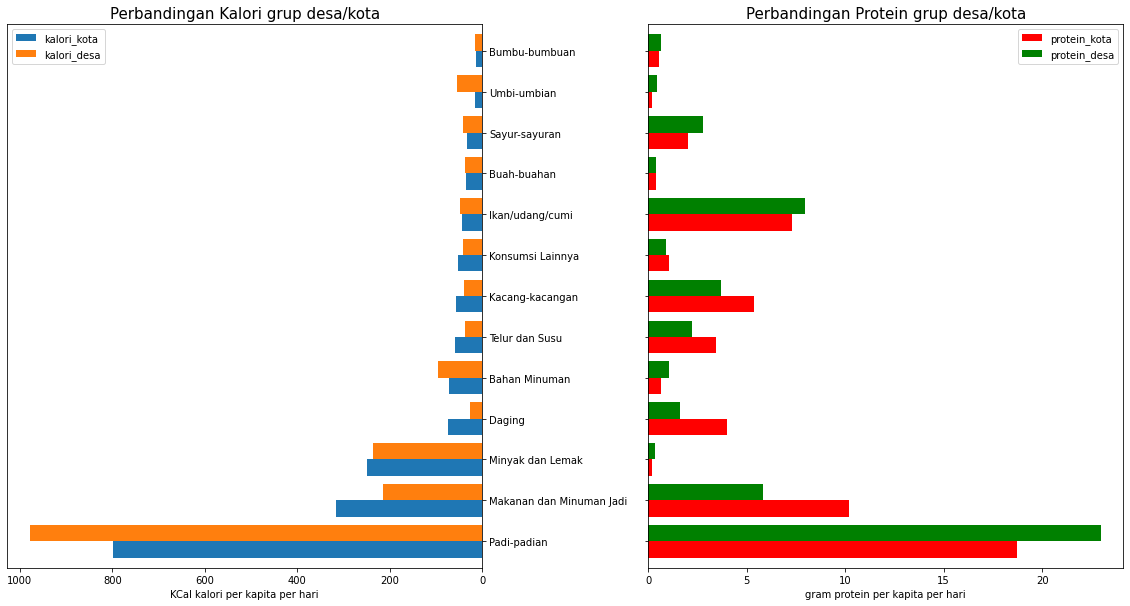

In [268]:
fig, axes = plt.subplots(ncols = 2, sharey = True, figsize = (20,10))
gizi_kota_desa.loc[:,['kalori_kota','kalori_desa']].plot(kind = 'barh', ax = axes[0], width=0.8)
gizi_kota_desa.loc[:,['protein_kota','protein_desa']].plot(kind = 'barh', ax = axes[1],width=0.8, color=['r','g'])

axes[0].invert_xaxis()
axes[0].yaxis.tick_right()
axes[0].set_ylabel("")
axes[0].set_xlabel("KCal kalori per kapita per hari")
axes[0].set_title("Perbandingan Kalori grup desa/kota", fontsize=15)

axes[1].set_xlabel("gram protein per kapita per hari")
axes[1].set_title("Perbandingan Protein grup desa/kota", fontsize=15)
plt.subplots_adjust(wspace = 0.35)
plt.show()

### C. Harga dan total pengeluaran per kelompok makanan 

### D. Perbandingan total konsumsi makanan per konsumsi total

# 5. Konsumsi air (ml/hari/kapita)

# 6. Korelasi antar indikator gizi

# 7. Korelasi dengan variabel lain

# 8. Data panel ke 2013 ??

1. buat model simple :
hubungan pendapatan/pengeluaran, tingkat pendidikan, usia kepala keluarga, daerah kota/desa , kekayaan (tentatif) , terhadap akg nya

#### Aggregasi tingkat kabupaten/kota

kemudian kita aggregasi ke tingkat kabupaten/kota

In [89]:
# Creating Lambda Function for Weighted Average and Weighted Sum
wt_mean = lambda x: np.average(x, weights=gizi_grouped_daily_daerah.loc[x.index, "WERT"])
wt_sum = lambda x: np.sum(x, weights=gizi_grouped_daily_daerah.loc[x.index, "WERT"])


gizi_kabkota = gizi_grouped_daily_daerah.groupby(['nama_prov','Label']).agg(kalori = ('kalori', wt_mean),
                                                     protein = ('protein', wt_mean),
                                                     lemak = ('lemak', wt_mean),
                                                     karbohidrat = ('karbohidrat', wt_mean),
#                                                      WEIND = ('WEIND', 'mean')
                                                     WERT = ('WERT', 'sum')).reset_index('nama_prov')
gizi_kabkota

,nama_prov,kalori,protein,lemak,karbohidrat,WERT
Label,,,,,,
Aceh Barat,Aceh,1686.216718,49.112493,45.390911,242.917228,181770.125938
Aceh Barat Daya,Aceh,1885.099198,49.736744,35.948125,306.595904,132927.222007
Aceh Besar,Aceh,1812.548884,53.671842,42.324263,278.622117,368743.028731
Aceh Jaya,Aceh,2156.433098,63.780067,52.594420,325.503570,82962.881689
Aceh Selatan,Aceh,1970.410176,52.343946,42.844708,316.200031,212355.504311
...,...,...,...,...,...,...
Tapanuli Selatan,Sumatera Utara,2228.177135,57.926773,44.142485,371.239144,265974.457187
Tapanuli Tengah,Sumatera Utara,1796.487814,51.532546,34.151353,296.197249,324285.717659
Tapanuli Utara,Sumatera Utara,1993.374662,56.724811,34.872185,333.451640,282493.850134
